 - Importing Libraries
 - Data Processing
     - Data loading
     - Data visualization
 - Data Augmentation
     - Translation
     - Rotation
     - Combining augmented and original data
 - Building CNN Model
     - Basic architecture:
         - **(conv --> relu --> maxpool)*3 --> fc1 --> output**
     - defining hyperparameters
     - defining convolution and maxpool functions
     - initializing weights and biases
     - creating cnn model
     - prediction using model
     - checking training and testing accuracy
     - **due to limitation of computation time, only 10 iterations(epochs) are performed**
     - maximum test accuracy is achieved at 7th epoch:
         - test_set accuracy = __53.44%__
         - training_set accuracy = __82.03%__
     
 - Modifying above CNN model using batch normalization and dropout:
     - Basic architecture:
         - **(conv --> relu--> maxpool --> dropout --> bn)*3 --> fc1 --> dropout --> bn --> output**
     - creating cnn-bn model
     - prediction using model
     - checking training and testing accuracy
     - **due to limitation of computation time, only 10 iterations(epochs) are performed**
     - maximum test accuracy is achieved at 6th epoch
         - test_set accuracy = __47.15%__
         - training_set accuracy = __77.34%__

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mlxtend.data import loadlocal_mnist
tf.logging.set_verbosity(tf.logging.ERROR) #to suppress errors

# Data Processing

In [2]:
x_train, y_train = loadlocal_mnist(images_path='train-images-idx3-ubyte', labels_path='train-labels-idx1-ubyte')
x_test, y_test = loadlocal_mnist(images_path='t10k-images-idx3-ubyte', labels_path='t10k-labels-idx1-ubyte')

In [3]:
#normalizing the input data

x_train = x_train/255
x_test = x_test/255

In [4]:
#hot encoding of labels

def onehot(y):
    return np.eye(10)[y]

y_train = onehot(y_train)
y_test = onehot(y_test)
x_train = x_train.reshape(len(x_train),28,28,1)
x_test = x_test.reshape(len(x_test),28,28,1)

In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)


Text(0.5, 1.0, 'Label : Ankle_boot')

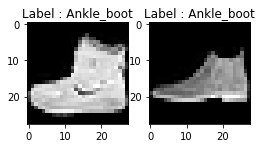

In [6]:
#data visualization

#dictionary containing all the labels in the output
label_dict = {0:'T-shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle_boot'}

#size of the figure
plt.figure(figsize=[4,4])

#assigning leftmost part of the above figure which has 1 row and 2 columns
plt.subplot(1,2,1)
image_train = np.reshape(x_train[0], (28,28)) #extracting first training image of size (28,28)
label_train = np.argmax(y_train[0,:]) #extracting label for the first training image
plt.imshow(image_train, cmap='gray')
plt.title('Label : ' + str(label_dict[label_train]))

#assigning rightmost part of the above figure which has 1 row and 2 columns
plt.subplot(1,2,2)
image_test = np.reshape(x_test[0], (28,28)) #extracting first test image of size (28,28)
label_test = np.argmax(y_test[0,:]) #extracting label for the first test image
plt.imshow(image_test, cmap='gray')
plt.title('Label : ' + str(label_dict[label_test]))

# Data Augmentation

In [7]:
import cv2

In [8]:
#width = number of columns
#height = number of rows

n, rows, cols = x_train.shape[0], x_train.shape[1], x_train.shape[2]
print(n, rows, cols)

60000 28 28


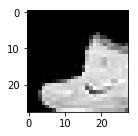

In [9]:
#Translation

def translation(x_train):
    translated = []
    for i in range(n):
        M = np.float32([[1,0,3],[0,1,3]])
        distorted = cv2.warpAffine(x_train[i], M, (cols,rows))
        translated.append(distorted)
    return translated

trans = translation(x_train)

plt.figure(figsize=[4,4])
plt.subplot(1,2,1)
image = np.reshape(trans[0], (28,28))
plt.imshow(image, cmap='gray')

In [10]:
# augmented data after translation

trans_aug = np.reshape(trans, (-1,28,28,1))
print(trans_aug.shape)

(60000, 28, 28, 1)


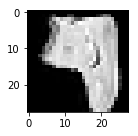

In [11]:
#Rotation

def rotation(x_train):
    rotated = []
    for i in range(n):
        M = cv2.getRotationMatrix2D((cols/2, rows/2), 90, 1)
        distorted = cv2.warpAffine(x_train[i],M,(cols,rows))
        rotated.append(distorted)
    return rotated

rot = rotation(x_train)

plt.figure(figsize=[4,4])
plt.subplot(121)
image = np.reshape(rot[0], (28,28))
plt.imshow(image, cmap='gray')

In [12]:
# augmented data after rotation

rot_aug = np.reshape(rot, (-1,28,28,1))
rot_aug.shape

(60000, 28, 28, 1)

In [13]:
#final training data

x_train1 = np.concatenate((x_train, trans_aug, rot_aug)) #(180000, 28, 28, 1)
y_train1 = np.concatenate((y_train, y_train, y_train))   #(180000, 10)

In [16]:
from sklearn.utils import shuffle
x_train1, y_train1 = shuffle(x_train1, y_train1, random_state=0)

# CNN Model

In [17]:
#hyperparameters

learning_rate = 0.001
batch_size = 128

In [18]:
num_classes = 10

x = tf.placeholder('float', [None, 28, 28, 1])
y = tf.placeholder('float', [None, num_classes])

In [19]:
#strides[0]=1 means that we do not want to skip any data(example) in the batch
#strides[1]=1 means that we do not want to skip any row
#strides[2]=1 means that we do not want to skip any column
#strides[3]=1 means that we do not want to skip in the channel

#"VALID" means no padding
#"SAME" results in padding the input such that the output has the same length as the original input

def conv(x, w, b, s=1):
    x = tf.nn.conv2d(x, w , strides = [1, s, s, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')

In [20]:
#'wc1' - for first conv layer
#'wc2' - for second conv layer
#'wc3' - for third conv layer
#'wd1' - for dense layer
#'out' - for output layer

weights = {'wc1': tf.get_variable('w1', shape=(3,3,1,32), initializer=tf.random_normal_initializer()),
           'wc2': tf.get_variable('w2', shape=(3,3,32,64), initializer=tf.random_normal_initializer()),
           'wc3': tf.get_variable('w3', shape=(3,3,64,128), initializer=tf.random_normal_initializer()),
           'wd1': tf.get_variable('w4', shape=(3*3*128,128), initializer=tf.random_normal_initializer()),
           'out': tf.get_variable('w5', shape=(128,num_classes), initializer=tf.random_normal_initializer())}
           #128 - batch size; num_classes - 10
    
biases = {'bc1': tf.get_variable('b1', shape=(32), initializer=tf.random_normal_initializer()),
          'bc2': tf.get_variable('b2', shape=(64), initializer=tf.random_normal_initializer()),
          'bc3': tf.get_variable('b3', shape=(128), initializer=tf.random_normal_initializer()),
          'bd1': tf.get_variable('b4', shape=(128), initializer=tf.random_normal_initializer()),
          'out': tf.get_variable('b5', shape=(10), initializer=tf.random_normal_initializer())}

In [21]:
def conv_net(x, weights, biases):
#     print(x.shape)
    conv1 = conv(x, weights['wc1'], biases['bc1'])  #(28,28,1) ---> (28,28,32)
#     print(conv1.shape)
    conv1 = maxpool(conv1, k=2) #(28,28,32) ---> (14,14,32)
#     print(conv1.shape)
    conv2 = conv(conv1, weights['wc2'], biases['bc2']) #(14,14,32) ---> (14,14,64)
#     print(conv2.shape)
    conv2 = maxpool(conv2, k=2) #(14,14,64) ---> (7,7,64)
#     print(conv2.shape)
    conv3 = conv(conv2, weights['wc3'], biases['bc3']) #(7,7,64) ---> (7,7,128)
#     print(conv3.shape)
    conv3 = maxpool(conv3, k=2) #(7,7,128) ---> (3,3,128)
#     print(conv3.shape)
    
    fc1 = tf.reshape(conv3, [-1, 3*3*128]) #(batch, 1152)
#     print(fc1.shape)
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1']) #(batch,1152)*(1152,128) -> (batch,128)
#     print(fc1.shape)
    
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out']) #(batch,128)*(128,10) -> (batch,10)
#     print(out.shape)
    
    return out #(batch,10)

In [22]:
y_pred = conv_net(x, weights, biases)

#The reason we use cross entropy as a loss/cost function is because
#the cross-entropy function's value is always positive, and 
#tends toward zero as the neuron gets better at computing the desired output

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [23]:
correct_pred = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y,1)) #of boolean data type

accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [24]:
print("Number of batches = ",len(x_train1)//batch_size)

Number of batches =  1406


In [ ]:
iters = 10

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    saver = tf.train.Saver()
    accu = 0
    
    for i in range(iters):
        for batch in range(len(x_train1)//batch_size):
            x_batch = x_train1[batch*batch_size:min((batch+1)*batch_size, len(x_train1))]
            y_batch = y_train1[batch*batch_size:min((batch+1)*batch_size, len(y_train1))]
            
            opt = sess.run(optimizer, feed_dict={x:x_batch, y:y_batch})
            
            loss, acc = sess.run([cost, accuracy], feed_dict={x:x_batch, y:y_batch})
        
        print("epoch " + str(i+1) + ", Loss= " + "{:.6f}".format(loss) + ", Training Accuracy = " + \
             "{:.5f}".format(acc))
        print("Optimization Finished!")
        
        test_acc, valid_loss = sess.run([accuracy, cost], feed_dict={x:x_test, y:y_test})
        
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        
        print("Testing Accuracy:", "{:.5f}".format(test_acc))
        
        if(test_acc > accu):
            accu = test_acc
            saver.save(sess,'result')
            
#     summary.close()

epoch 1, Loss= 3418.697510, Training Accuracy = 0.65625
Optimization Finished!
Testing Accuracy: 0.69860
epoch 2, Loss= 1393.191895, Training Accuracy = 0.74219
Optimization Finished!
Testing Accuracy: 0.74900
epoch 3, Loss= 951.273438, Training Accuracy = 0.75000
Optimization Finished!
Testing Accuracy: 0.75700
epoch 4, Loss= 519.903503, Training Accuracy = 0.78125
Optimization Finished!
Testing Accuracy: 0.77190
epoch 5, Loss= 332.747162, Training Accuracy = 0.76562
Optimization Finished!


In [1]:
max(test_accuracy)

NameError: name 'test_accuracy' is not defined

In [41]:
max(train_accuracy)

0.8515625

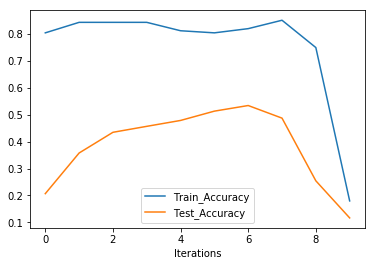

In [23]:
plt.plot(np.arange(10), train_accuracy, label='Train_Accuracy')
plt.plot(np.arange(10), test_accuracy, label='Test_Accuracy')

plt.xlabel('Iterations')
plt.legend()

# Modifying the above architecture using batch normalization, dropout

In [28]:
def conv_net_bn(x, weights, biases):
    conv1 = conv(x, weights['wc1'], biases['bc1'])  #(28,28,1) ---> (28,28,32)
    conv1 = maxpool(conv1, k=2) #(28,28,32) ---> (14,14,32)
    conv1 = tf.layers.batch_normalization(conv1, momentum=0.9)
#     conv1 = tf.layers.dropout(conv1, rate=0.4) #40% inputs get removed
    
    conv2 = conv(conv1, weights['wc2'], biases['bc2']) #(14,14,32) ---> (14,14,64)
    conv2 = maxpool(conv2, k=2) #(14,14,64) ---> (7,7,64)
#     conv2 = tf.layers.dropout(conv2, rate=0.4)
    conv2 = tf.layers.batch_normalization(conv2, momentum=0.9)
    
    
    conv3 = conv(conv2, weights['wc3'], biases['bc3']) #(7,7,64) ---> (7,7,128)
    conv3 = maxpool(conv3, k=2) #(7,7,128) ---> (3,3,128)
#     conv3 = tf.layers.dropout(conv3, rate=0.4)
    conv3 = tf.layers.batch_normalization(conv3, momentum=0.9)
    
    
    fc1 = tf.reshape(conv3, [-1, 3*3*128]) #(batch, 1152)
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1']) #(batch,1152)*(1152,128) -> (batch,128)
    fc1 = tf.layers.dropout(fc1, rate=0.4)
    fc1 = tf.layers.batch_normalization(fc1, momentum=0.9)
    
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out']) #(batch,128)*(128,10) -> (batch,10)
    
    return out #(batch,10)

In [29]:
y_pred_bn = conv_net_bn(x, weights, biases)

#The reason we use cross entropy as a loss/cost function is because
#the cross-entropy function's value is always positive, and 
#tends toward zero as the neuron gets better at computing the desired output

cost_bn = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_bn, labels=y))

optimizer_bn = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_bn)

In [ ]:
correct_pred_bn = tf.equal(tf.argmax(y_pred_bn, 1), tf.argmax(y,1)) #of boolean data type

accuracy_bn = tf.reduce_mean(tf.cast(correct_pred_bn, tf.float32))

In [33]:
iters = 10

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    train_loss_bn = []
    train_accuracy_bn = []
    test_loss_bn = []
    test_accuracy_bn = []
    saver_bn = tf.train.Saver()
    accu_bn = 0
    
    for i in range(iters):
        for batch in range(len(x_train1)//batch_size):
            x_batch = x_train1[batch*batch_size:min((batch+1)*batch_size, len(x_train1))]
            y_batch = y_train1[batch*batch_size:min((batch+1)*batch_size, len(y_train1))]
            
            opt_bn = sess.run(optimizer_bn, feed_dict={x:x_batch, y:y_batch})
            
            loss_bn, acc_bn = sess.run([cost_bn, accuracy_bn], feed_dict={x:x_batch, y:y_batch})
        
        print("epoch " + str(i+1) + ", Loss= " + "{:.6f}".format(loss_bn) + ", Training Accuracy = " + \
             "{:.5f}".format(acc_bn))
        print("Optimization Finished!")
        
        test_acc_bn, valid_loss_bn = sess.run([accuracy_bn, cost_bn], feed_dict={x:x_test, y:y_test})
        
        train_loss_bn.append(loss_bn)
        test_loss_bn.append(valid_loss_bn)
        train_accuracy_bn.append(acc_bn)
        test_accuracy_bn.append(test_acc_bn)
        
        print("Testing Accuracy:", "{:.5f}".format(test_acc_bn))
        
        if(test_acc_bn > accu_bn):
            accu_bn = test_acc_bn
            saver_bn.save(sess,'result_bn')
    
#     summary.close()

epoch 1, Loss= 1683.454590, Training Accuracy = 0.72656
Optimization Finished!
Testing Accuracy: 0.11610
epoch 2, Loss= 604.589294, Training Accuracy = 0.78125
Optimization Finished!
Testing Accuracy: 0.25960
epoch 3, Loss= 422.064178, Training Accuracy = 0.80469
Optimization Finished!
Testing Accuracy: 0.36550
epoch 4, Loss= 213.842468, Training Accuracy = 0.81250
Optimization Finished!
Testing Accuracy: 0.41090
epoch 5, Loss= 126.933929, Training Accuracy = 0.81250
Optimization Finished!
Testing Accuracy: 0.46250
epoch 6, Loss= 78.478882, Training Accuracy = 0.77344
Optimization Finished!
Testing Accuracy: 0.47150
epoch 7, Loss= 39.262947, Training Accuracy = 0.79688
Optimization Finished!
Testing Accuracy: 0.38030
epoch 8, Loss= 15.683969, Training Accuracy = 0.81250
Optimization Finished!
Testing Accuracy: 0.38700
epoch 9, Loss= 5.816041, Training Accuracy = 0.77344
Optimization Finished!
Testing Accuracy: 0.25540
epoch 10, Loss= 2.262261, Training Accuracy = 0.77344
Optimization F

In [38]:
max(test_accuracy_bn)

0.4715

In [39]:
max(train_accuracy_bn)

0.8125

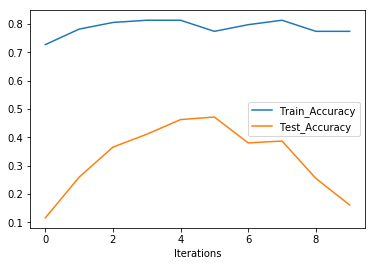

In [34]:
plt.plot(np.arange(10), train_accuracy_bn, label='Train_Accuracy')
plt.plot(np.arange(10), test_accuracy_bn, label='Test_Accuracy')

plt.xlabel('Iterations')
plt.legend()